In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score

# ------------------------------
# 1. U-Net Model Definition (Grayscale Input)
# ------------------------------
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder (Downsampling)
        self.enc1 = self.conv_block(1, 64)      # Input: 1 channel (grayscale)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Upsampling)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Output layer for binary segmentation
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)                   # [B, 64, 512, 512]
        enc2 = self.enc2(self.pool1(enc1))      # [B, 128, 256, 256]
        enc3 = self.enc3(self.pool2(enc2))      # [B, 256, 128, 128]
        enc4 = self.enc4(self.pool3(enc3))      # [B, 512, 64, 64]

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))  # [B, 1024, 32, 32]

        # Decoder
        dec4 = self.upconv4(bottleneck)         # [B, 512, 64, 64]
        dec4 = torch.cat((dec4, enc4), dim=1)     # [B, 1024, 64, 64]
        dec4 = self.dec4(dec4)                  # [B, 512, 64, 64]

        dec3 = self.upconv3(dec4)               # [B, 256, 128, 128]
        dec3 = torch.cat((dec3, enc3), dim=1)     # [B, 512, 128, 128]
        dec3 = self.dec3(dec3)                  # [B, 256, 128, 128]

        dec2 = self.upconv2(dec3)               # [B, 128, 256, 256]
        dec2 = torch.cat((dec2, enc2), dim=1)     # [B, 256, 256, 256]
        dec2 = self.dec2(dec2)                  # [B, 128, 256, 256]

        dec1 = self.upconv1(dec2)               # [B, 64, 512, 512]
        dec1 = torch.cat((dec1, enc1), dim=1)     # [B, 128, 512, 512]
        dec1 = self.dec1(dec1)                  # [B, 64, 512, 512]

        out = self.conv_last(dec1)              # [B, 1, 512, 512]
        return torch.sigmoid(out)

# ------------------------------
# 2. Dataset with Albumentations (Grayscale)
# ------------------------------
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        """
        images_dir: Directory with input images (JPG, loaded as grayscale).
        masks_dir: Directory with corresponding segmentation masks (PNG, loaded as grayscale).
        transform: Albumentations transform that applies jointly to image and mask.
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images_list = os.listdir(images_dir)

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        img_name = self.images_list[idx]
        img_path = os.path.join(self.images_dir, img_name)
        # Assuming mask names correspond to the image name (without extension) plus '.png'
        mask_path = os.path.join(self.masks_dir, os.path.splitext(img_name)[0] + '.png')

        # Load image as grayscale (1 channel)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Image not found at path: {img_path}")

        # Load mask as grayscale (1 channel)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Mask not found at path: {mask_path}")

        # Apply augmentation if provided.
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask = (mask > 0.5).float()  # Now strictly 0 or 1

        # Ensure mask has shape [1, H, W]
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)

        return image, mask

def dice_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    smooth = 1e-6
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
def compute_metrics(preds, targets):
    preds = (preds > 0.5).float().cpu().numpy().flatten()
    targets = targets.cpu().numpy().flatten()

    precision = precision_score(targets, preds, zero_division=0)
    recall = recall_score(targets, preds, zero_division=0)
    return precision, recall

D:\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\python\Lib\site-packages\albumentations\check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno 11001] getaddrinfo failed>
  data = fetch_version_info()


In [2]:
# ------------------------------
# 3. Albumentations Transform for Grayscale Images
# ------------------------------
transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # Normalize the image; the mask will be thresholded later
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# ------------------------------
# 4. DataLoader Setup (Batch size set to 2 for lower GPU memory usage)
# ------------------------------
images_dir = 'U-net data/images'
masks_dir = 'U-net data/mask'

dataset = SegmentationDataset(images_dir, masks_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)

# ------------------------------
# 5. Training Setup
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()  # For binary segmentation.
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ------------------------------
# 6. Training Loop
# ------------------------------
num_epochs = 40
best_loss = float('inf')

losses = []
precisions = []
recalls = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    dice_total = 0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        dice = dice_score(outputs, masks)
        dice_total += dice.item()
        optimizer.step()

        epoch_loss += loss.item()
        precision, recall = compute_metrics(outputs, masks)
    # Free unused GPU memory after each epoch
    torch.cuda.empty_cache()
    avg_loss = epoch_loss / len(dataloader)
    #avg_precision = precision / len(dataloader)
    #avg_recall = recall / len(dataloader)
    avg_dice = dice_total / len(dataloader)
    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Dice: {avg_dice:.4f} , Recall: {avg_recall:.4f} , Precision: {avg_precision:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Dice: {avg_dice:.4f} ")
    if avg_loss < best_loss:
       best_loss = avg_loss
       torch.save(model.state_dict(), "best_model.pth")
       print("Best model saved.")



Epoch [1/40], Loss: 0.5371
Epoch [1/40], Loss: 0.5371, Dice: 0.4095
Best model saved.
Epoch [2/40], Loss: 0.3328
Epoch [2/40], Loss: 0.3328, Dice: 0.7866
Best model saved.
Epoch [3/40], Loss: 0.2837
Epoch [3/40], Loss: 0.2837, Dice: 0.7979
Best model saved.
Epoch [4/40], Loss: 0.2792
Epoch [4/40], Loss: 0.2792, Dice: 0.8005
Best model saved.
Epoch [5/40], Loss: 0.2707
Epoch [5/40], Loss: 0.2707, Dice: 0.7975
Best model saved.
Epoch [6/40], Loss: 0.2631
Epoch [6/40], Loss: 0.2631, Dice: 0.8062
Best model saved.
Epoch [7/40], Loss: 0.2622
Epoch [7/40], Loss: 0.2622, Dice: 0.8179
Best model saved.
Epoch [8/40], Loss: 0.2525
Epoch [8/40], Loss: 0.2525, Dice: 0.8112
Best model saved.
Epoch [9/40], Loss: 0.2445
Epoch [9/40], Loss: 0.2445, Dice: 0.8296
Best model saved.
Epoch [10/40], Loss: 0.2395
Epoch [10/40], Loss: 0.2395, Dice: 0.8344
Best model saved.
Epoch [11/40], Loss: 0.2305
Epoch [11/40], Loss: 0.2305, Dice: 0.8466
Best model saved.
Epoch [12/40], Loss: 0.2300
Epoch [12/40], Loss: 0

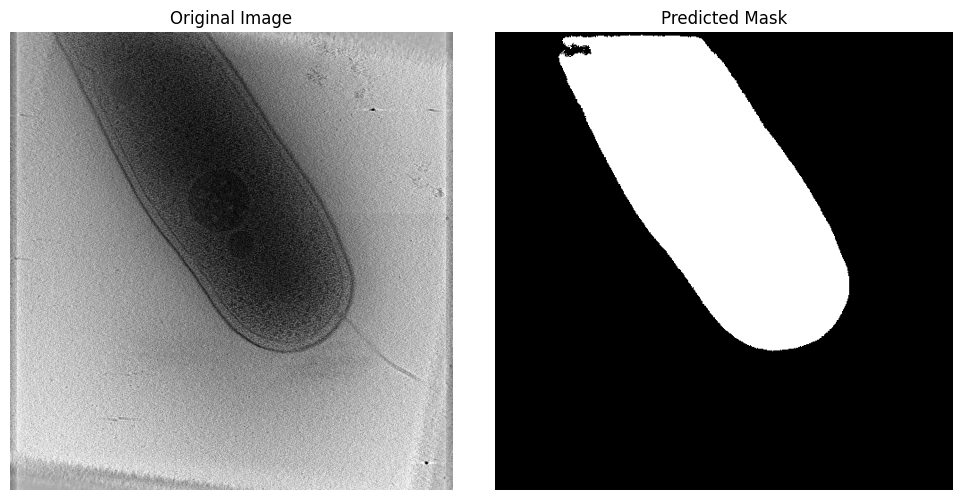

In [11]:
import matplotlib.pyplot as plt
def load_image(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    # Expand dimensions to HxWx1 for Albumentations
    image = image[..., None]
    return image

def predict_image(model, image_path, transform=None, device='cpu'):
    model.eval()  # Set model to evaluation mode

    # Load the image
    image = load_image(image_path)

    # Apply transformation if provided
    if transform is not None:
        augmented = transform(image=image)
        image_tensor = augmented['image']
    else:
        # If no transform provided, use ToTensorV2 by default
        image_tensor = ToTensorV2()(image=image)['image']

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        # Forward pass through the model
        output = model(image_tensor)

        predicted_mask = (output > 0.5).float()

    # Remove the batch dimension and convert to CPU for visualization
    predicted_mask = predicted_mask.squeeze().cpu().numpy()
    # print(output.min(), output.max())  # Check the min and max values
    #plt.imshow(output.squeeze().cpu().numpy(), cmap='gray')  # Visualize raw output
    #plt.show()
    return predicted_mask

# Example usage:
if __name__ == '__main__':

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)  # Replace with your model class
    model.load_state_dict(torch.load('best_model3.pth', map_location=device))

    # Define the transform identical to what you used in training/evaluation
    transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
    ])

    # Path to the image you want to predict
    image_path = 'target/slice_0031.jpg'
    predicted_mask = predict_image(model, image_path, transform=transform, device='cuda')

    # Visualize the original image and the predicted mask
    original_image = load_image(image_path).squeeze()  # remove channel dim for display
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
import cv2
import numpy as np

def overlay_mask_boundaries(image, mask, boundary_width=5):
    """
    Overlay the boundaries of the mask on the original image with a specified width.

    Args:
        image (numpy.ndarray): Original image in BGR format.
        mask (numpy.ndarray): Predicted mask (2D array, 0s and 1s or 0s and 255).
        boundary_width (int): Width of the boundary line in pixels.

    Returns:
        numpy.ndarray: Image with mask boundaries highlighted.
    """
    # Ensure mask is 2D and of type uint8
    if mask.ndim > 2:
        mask = mask.squeeze()
    if mask.dtype != np.uint8:
        mask = (mask * 255).astype(np.uint8)

    # Resize mask to match image dimensions if necessary
    if mask.shape[:2] != image.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the boundaries
    boundary_mask = np.zeros_like(mask)
    cv2.drawContours(boundary_mask, contours, -1, 255, thickness=boundary_width)

    # Apply the boundary mask to the original image
    result = cv2.bitwise_and(image, image, mask=boundary_mask)

    return result


In [8]:
def overlay_mask_boundaries(image, mask, boundary_width=5):
    """
    Overlay the boundaries of the mask on the original image with a specified width.

    Args:
        image (numpy.ndarray): Original image in BGR format.
        mask (numpy.ndarray): Predicted mask (2D array, 0s and 1s or 0s and 255).
        boundary_width (int): Width of the boundary line in pixels.

    Returns:
        numpy.ndarray: Image with mask boundaries highlighted.
    """
    # Ensure mask is 2D and of type uint8
    if mask.ndim > 2:
        mask = mask.squeeze()
    if mask.dtype != np.uint8:
        mask = (mask * 255).astype(np.uint8)

    # Resize mask to match image dimensions if necessary
    if mask.shape[:2] != image.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the boundaries
    boundary_mask = np.zeros_like(mask)
    cv2.drawContours(boundary_mask, contours, -1, 255, thickness=boundary_width)

    # Apply the boundary mask to the original image
    result = cv2.bitwise_and(image, image, mask=boundary_mask)

    return result


In [7]:
# Assuming 'model' is your trained model and 'image' is your input image
image_path = 'target/slice_0104.jpg'
mask = predict_image(model, image_path, transform=transform, device='cuda')
# Visualize the original image and the predicted mask
original_image = load_image(image_path).squeeze()  # remove channel dim for display
result_image = overlay_mask_boundaries(original_image, mask, boundary_width=50)

original_image = load_image(image_path).squeeze()  # remove channel dim for display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result_image, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'predict_image' is not defined

In [16]:
import os
from PIL import Image

# Define the input and output folder paths
input_folder = "target1"
output_folder = "processed_target"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Iterate through all files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
        image_path = os.path.join(input_folder, filename)
        mask = predict_image(model, image_path, transform=transform, device='cuda')
        # Visualize the original image and the predicted mask
        original_image = load_image(image_path).squeeze()
        result_image = overlay_mask_boundaries(original_image, mask, boundary_width=50)
        # Save the processed image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, result_image)

print("Processing complete!")


Processing complete!


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

class UNet(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(UNet, self).__init__()
        # Encoder (Downsampling)
        self.enc1 = self.conv_block(1, 64)  # Input: 1 channel (grayscale)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck with dropout
        self.bottleneck = self.conv_block(512, 1024)
        self.dropout = nn.Dropout2d(p=dropout_rate)

        # Decoder (Upsampling)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Output layer for binary segmentation
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

        # Initialize weights
        self.initialize_weights()

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added batch normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added batch normalization
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)  # [B, 64, 512, 512]
        enc2 = self.enc2(self.pool1(enc1))  # [B, 128, 256, 256]
        enc3 = self.enc3(self.pool2(enc2))  # [B, 256, 128, 128]
        enc4 = self.enc4(self.pool3(enc3))  # [B, 512, 64, 64]

        # Bottleneck with dropout
        bottleneck = self.bottleneck(self.pool4(enc4))  # [B, 1024, 32, 32]
        bottleneck = self.dropout(bottleneck)  # Apply dropout

        # Decoder
        dec4 = self.upconv4(bottleneck)  # [B, 512, 64, 64]
        dec4 = torch.cat((dec4, enc4), dim=1)  # [B, 1024, 64, 64]
        dec4 = self.dec4(dec4)  # [B, 512, 64, 64]

        dec3 = self.upconv3(dec4)  # [B, 256, 128, 128]
        dec3 = torch.cat((dec3, enc3), dim=1)  # [B, 512, 128, 128]
        dec3 = self.dec3(dec3)  # [B, 256, 128, 128]

        dec2 = self.upconv2(dec3)  # [B, 128, 256, 256]
        dec2 = torch.cat((dec2, enc2), dim=1)  # [B, 256, 256, 256]
        dec2 = self.dec2(dec2)  # [B, 128, 256, 256]

        dec1 = self.upconv1(dec2)  # [B, 64, 512, 512]
        dec1 = torch.cat((dec1, enc1), dim=1)  # [B, 128, 512, 512]
        dec1 = self.dec1(dec1)  # [B, 64, 512, 512]

        out = self.conv_last(dec1)  # [B, 1, 512, 512]
        return torch.sigmoid(out)

    def initialize_weights(self):
        """Initialize model weights using Kaiming initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)



# Dice coefficient for evaluation
def dice_coeff(pred, target):
    smooth = 1.0
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)


In [6]:

# Training function
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, device='cuda'):
    # Move model to device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_dice': []
    }

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for images, masks in progress_bar:
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update statistics
            train_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=loss.item())

        # Calculate average training loss
        train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0

        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Validation]')
            for images, masks in progress_bar:
                # Move data to device
                images = images.to(device)
                masks = masks.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)

                # Calculate dice coefficient
                dice = dice_coeff(outputs, masks)

                # Update statistics
                val_loss += loss.item() * images.size(0)
                val_dice += dice.item() * images.size(0)
                progress_bar.set_postfix(loss=loss.item(), dice=dice.item())

        # Calculate average validation loss and dice
        val_loss = val_loss / len(val_loader.dataset)
        val_dice = val_dice / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)

        # Update learning rate
        scheduler.step(val_loss)

        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}')

    return model, history


# Example of usage
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create datasets and dataloaders
    train_dataset = SegmentationDataset(num_samples=500, img_size=256)  # Reduced size for example
    val_dataset = SegmentationDataset(num_samples=100, img_size=256)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

    # Create model
    model = UNet(dropout_rate=0.2)

    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")

    # Train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=10,
        lr=0.001,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_dice'], label='Validation Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    plt.title('Validation Dice Coefficient')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

    # Save the trained model
    torch.save(trained_model.state_dict(), 'unet_model.pth')
    print("Model saved to 'unet_model.pth'")

Using device: cuda


TypeError: SegmentationDataset.__init__() got an unexpected keyword argument 'num_samples'

In [6]:
# ------------------------------
# 3. Albumentations Transform for Grayscale Images
# ------------------------------
transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # Normalize the image; the mask will be thresholded later
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# ------------------------------
# 4. DataLoader Setup (Batch size set to 2 for lower GPU memory usage)
# ------------------------------
images_dir = 'U-net data/images'
masks_dir = 'U-net data/mask'

dataset = SegmentationDataset(images_dir, masks_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)

# ------------------------------
# 5. Training Setup
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(dropout_rate=0.2).to(device)
model.load_state_dict(torch.load('best_model3.pth', map_location=device))
criterion = nn.BCELoss()  # For binary segmentation.
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# ------------------------------
# 6. Training Loop
# ------------------------------
num_epochs = 10
best_loss = 0.0678

losses = []
precisions = []
recalls = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    dice_total = 0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        dice = dice_score(outputs, masks)
        dice_total += dice.item()
        optimizer.step()

        epoch_loss += loss.item()
        precision, recall = compute_metrics(outputs, masks)
    # Free unused GPU memory after each epoch
    torch.cuda.empty_cache()
    avg_loss = epoch_loss / len(dataloader)
    #avg_precision = precision / len(dataloader)
    #avg_recall = recall / len(dataloader)
    avg_dice = dice_total / len(dataloader)
    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Dice: {avg_dice:.4f} , Recall: {avg_recall:.4f} , Precision: {avg_precision:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Dice: {avg_dice:.4f} ")
    if avg_loss < best_loss:
       best_loss = avg_loss
       torch.save(model.state_dict(), "best_model3.pth")
       print("Best model saved.")



Epoch [1/10], Loss: 0.0664, Dice: 0.9589 
Best model saved.
Epoch [2/10], Loss: 0.0562, Dice: 0.9643 
Best model saved.
Epoch [3/10], Loss: 0.0551, Dice: 0.9651 
Best model saved.
Epoch [4/10], Loss: 0.0572, Dice: 0.9649 
Epoch [5/10], Loss: 0.0532, Dice: 0.9661 
Best model saved.
Epoch [6/10], Loss: 0.0507, Dice: 0.9679 
Best model saved.
Epoch [7/10], Loss: 0.0483, Dice: 0.9695 
Best model saved.
Epoch [8/10], Loss: 0.0479, Dice: 0.9694 
Best model saved.
Epoch [9/10], Loss: 0.0436, Dice: 0.9722 
Best model saved.
Epoch [10/10], Loss: 0.0444, Dice: 0.9723 
